In [38]:
import os
# Set pyrender to use EGL for offscreen rendering (headless mode)
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pyrender
import trimesh

### 2. Object Twin (workload 3 students):
In this exercise, we will load a realsense-viewer rosbag recording, then use opencv and pyrender to create a twin of a moving checkerboard.
1. Loading color and depth data:
     * Use pyrealsense2 to read the bagfile and acquire color, depth, aligned depth to color, color camera intrinsics, depth camera intrinsics. (Show the images in a loop using `cv2.imshow`)
     
2. Checkerboard detection and tracking: 
     * The checkerboard has a `6x9` pattern where each square has an edge length of 4 cm.
     * Using opencv we want Find its corners (use `cv2.findChessboardCorners`, and `cv2.cornersSubPix`). then use `cv2.drawChessboardCorners` to overlay the detections on the colored image
     * From the previous step, you will have 2D/3D correspondences for the corners. Use `cv2.solvePnP` to estimate the object to camera translation and rotation vectors.
     * *Extra:* Use opencv drawing utils and perspective projection function to draw a 3D axis, and a cropping mask for the board. Useful functions here could be `cv2.line,cv2.projectPoints,cv2.fillPoly`.
3. Modeling the checkerboard in pyrender:
    * Using pyrender create a scene with camera and a `Box` mesh corresponding to the checkerboard.
    * Notes:
      1. You will need to scale the box and shift its center to match the checkerboard 3d coordinate system in opencv
      2. To convert from opencv camera to pyrender camera in you system you may need to rotate your objects by 90 degees around the X-axis (depending on your implementation) 
4. Visualization and Comparasion:
    * In the loop, update the mesh pose with the updated pose of the checkerboard
    * Compare the rendered depth value to the actual algined_depth values we got from realsense.
    * Optional: Report the Root Mean Squared Error RMSE between the rendered depth, and the actual depth within the detected area
a sample visualization could be seen in the figuire below
![image](assets/hw-1-2-example.png)

In [39]:
# Path to your .bag file
bag_file = "/workspace/NS1/01-Realsense/Homework/HW1-2-data/20220405_220626.bag"

# Create a pipeline
pipeline = rs.pipeline()

# Create a config object and configure it to use your recorded file
config = rs.config()
rs.config.enable_device_from_file(config, bag_file, repeat_playback=False)


In [46]:
## the following function here are for the checkerboard detection and tracking

def prepare_object_points(checkerboard_size, square_size):
    """
    Prepares 3D object points for the checkerboard in object coordinate system.
    
    Args:
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        square_size (float): Edge length of each square in meters.
    
    Returns:
        objp (np.ndarray): 3D points in object coordinate system (N x 3).
    """
    objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
    objp *= square_size
    return objp

def process_checkerboard(color_image, checkerboard_size, criteria):
    """
    Detects a checkerboard pattern in the given color image, refines corner locations, 
    and draws the detected corners on a copy of the input image.

    Args:
        color_image (np.ndarray): Input color image (RGB).
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        criteria: Termination criteria for cornerSubPix.

    Returns:
        color_for_draw (np.ndarray): Color image with overlaid detected corners (if found).
        found (bool): True if checkerboard is found, else False.
        corners2 (np.ndarray or None): Refined corner coordinates if found, else None.
    """
    # Convert color to grayscale for checkerboard detection
    gray = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

    # Try to find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    # Prepare the image for display (for matplotlib: needs RGBA)
    color_for_draw = color_image.copy()
    corners2 = None
    if found:
        # Refine corner locations
        corners2 = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria
        )
        # Draw the corners on the color image
        cv2.drawChessboardCorners(color_for_draw, checkerboard_size, corners2, found)

    return color_for_draw, found, corners2

def draw_3d_axis(image, rvec, tvec, camera_matrix, dist_coeffs, axis_length=0.1):
    """
    Draws 3D coordinate axes on the image using the pose estimation.
    
    Args:
        image (np.ndarray): Input image to draw on.
        rvec (np.ndarray): Rotation vector from solvePnP.
        tvec (np.ndarray): Translation vector from solvePnP.
        camera_matrix (np.ndarray): Camera intrinsic matrix.
        dist_coeffs (np.ndarray): Distortion coefficients.
        axis_length (float): Length of each axis in meters.
    
    Returns:
        image (np.ndarray): Image with drawn axes.
    """
    # Define 3D points for the axes (origin and three axis endpoints)
    axis_points = np.float32([
        [0, 0, 0],  # Origin
        [axis_length, 0, 0],  # X-axis (Red)
        [0, axis_length, 0],  # Y-axis (Green)
        [0, 0, axis_length]   # Z-axis (Blue)
    ]).reshape(-1, 3)
    
    # Project 3D points to 2D image plane
    imgpts, _ = cv2.projectPoints(axis_points, rvec, tvec, camera_matrix, dist_coeffs)
    imgpts = imgpts.reshape(-1, 2).astype(int)
    
    # Draw the axes
    origin = tuple(imgpts[0])
    image = cv2.line(image, origin, tuple(imgpts[1]), (255, 0, 0), 3)  # X-axis: Red
    image = cv2.line(image, origin, tuple(imgpts[2]), (0, 255, 0), 3)  # Y-axis: Green
    image = cv2.line(image, origin, tuple(imgpts[3]), (0, 0, 255), 3)  # Z-axis: Blue
    
    return image

def draw_board_mask(image, rvec, tvec, camera_matrix, dist_coeffs, checkerboard_size, square_size):
    """
    Draws a semi-transparent cropping mask for the checkerboard.
    
    Args:
        image (np.ndarray): Input image to draw on.
        rvec (np.ndarray): Rotation vector from solvePnP.
        tvec (np.ndarray): Translation vector from solvePnP.
        camera_matrix (np.ndarray): Camera intrinsic matrix.
        dist_coeffs (np.ndarray): Distortion coefficients.
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        square_size (float): Edge length of each square in meters.
    
    Returns:
        image (np.ndarray): Image with drawn mask.
    """
    # Define the 4 corner points of the board in 3D
    board_corners = np.float32([
        [0, 0, 0],
        [checkerboard_size[0] * square_size-square_size, 0, 0],
        [checkerboard_size[0] * square_size-square_size, checkerboard_size[1] * square_size-square_size, 0],
        [0, checkerboard_size[1] * square_size-square_size, 0]
    ]).reshape(-1, 3)
    
    # Project to 2D
    imgpts, _ = cv2.projectPoints(board_corners, rvec, tvec, camera_matrix, dist_coeffs)
    imgpts = imgpts.reshape(-1, 2).astype(int)
    
    # Create a semi-transparent overlay
    overlay = image.copy()
    cv2.fillPoly(overlay, [imgpts], (0, 255, 255))  # Yellow mask
    
    # Blend the overlay with the original image
    alpha = 0.2
    image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    
    # Draw the board outline
    cv2.polylines(image, [imgpts], True, (255, 0, 255), 1)  # Magenta outline
    
    return image


### Part 3: Modeling the Checkerboard in Pyrender (in Progress)

In this section, we'll create a 3D model of the checkerboard using pyrender and compare the rendered depth with the actual depth from the RealSense camera.


In [48]:
def create_checkerboard_mesh(checkerboard_size, square_size):
    """
    Creates a Box mesh representing the checkerboard.
    
    Args:
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        square_size (float): Edge length of each square in meters.
    
    Returns:
        mesh: Pyrender Mesh object representing the checkerboard.
    """
    # Calculate the dimensions of the checkerboard
    # The checkerboard has (rows+1) x (cols+1) squares
    width = checkerboard_size[0] * square_size
    height = checkerboard_size[1] * square_size
    thickness = 0.050  # 5mm thick board
    
    # Create a box mesh with trimesh
    # Note: trimesh box is centered at origin by default
    box = trimesh.creation.box(extents=[width, height, thickness])
    
    # Shift the box so that the top-left corner is at origin and the board is at z=0
    # In OpenCV coordinate system, the checkerboard origin is at the first corner
    # We need to translate so the center of the board aligns properly
    box.apply_translation([width/2, height/2, -thickness/2])
    
    # Create a pyrender mesh from the trimesh object
    mesh = pyrender.Mesh.from_trimesh(box)
    
    return mesh

def setup_pyrender_scene(camera_matrix, img_width, img_height):
    """
    Sets up a pyrender scene with camera.
    
    Args:
        camera_matrix (np.ndarray): Camera intrinsic matrix.
        img_width (int): Image width in pixels.
        img_height (int): Image height in pixels.
    
    Returns:
        scene: Pyrender Scene object.
        camera_node: Camera node in the scene.
    """
    # Create a scene
    scene = pyrender.Scene()
    
    # Create a camera from the intrinsic matrix
    # fx, fy are focal lengths, cx, cy are principal points
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]
    
    camera = pyrender.IntrinsicsCamera(fx=fx, fy=fy, cx=cx, cy=cy)
    
    # Add camera to scene at origin (camera coordinate system)
    camera_node = scene.add(camera, pose=np.eye(4))
    
    # Add a light to make the board visible (optional, helps with visualization)
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
    scene.add(light, pose=np.eye(4))
    
    return scene, camera_node

def opencv_to_pyrender_pose(rvec, tvec):
    """
    Converts OpenCV pose (rotation and translation vectors) to a 4x4 transformation matrix
    suitable for pyrender.
    
    Args:
        rvec (np.ndarray): Rotation vector from OpenCV (3x1).
        tvec (np.ndarray): Translation vector from OpenCV (3x1).
    
    Returns:
        pose (np.ndarray): 4x4 transformation matrix for pyrender.
    """
    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)
    
    # Create 4x4 transformation matrix
    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = tvec.ravel()
    
    # Convert from OpenCV to pyrender coordinate system
    # OpenCV: X right, Y down, Z forward
    # Pyrender: X right, Y up, Z backward
    # We need to rotate 180 degrees around X axis
    flip_yz = np.array([
        [1,  0,  0, 0],
        [0, -1,  0, 0],
        [0,  0, -1, 0],
        [0,  0,  0, 1]
    ])
    
    pose = flip_yz @ pose
    
    return pose

def render_depth(scene, renderer, img_width, img_height):
    """
    Renders the depth map from the pyrender scene.
    
    Args:
        scene: Pyrender Scene object.
        renderer: Pyrender OffscreenRenderer.
        img_width (int): Image width in pixels.
        img_height (int): Image height in pixels.
    
    Returns:
        depth (np.ndarray): Rendered depth map.
    """
    # Render the scene
    color, depth = renderer.render(scene)
    
    return depth

def compute_rmse(rendered_depth, actual_depth, mask):
    """
    Computes RMSE between rendered and actual depth within a mask.
    
    Args:
        rendered_depth (np.ndarray): Rendered depth map (in meters).
        actual_depth (np.ndarray): Actual depth map (in meters).
        mask (np.ndarray): Binary mask indicating valid region.
    
    Returns:
        rmse (float): Root Mean Squared Error.
    """
    # Extract depths within the mask
    rendered_valid = rendered_depth[mask > 0]
    actual_valid = actual_depth[mask > 0]
    
    # Filter out invalid depth values (zeros or NaNs)
    valid_indices = (rendered_valid > 0) & (actual_valid > 0) & np.isfinite(rendered_valid) & np.isfinite(actual_valid)
    
    if np.sum(valid_indices) == 0:
        return np.nan
    
    rendered_valid = rendered_valid[valid_indices]
    actual_valid = actual_valid[valid_indices]
    
    # Compute RMSE
    rmse = np.sqrt(np.mean((rendered_valid - actual_valid) ** 2))
    
    return rmse

def create_board_mask(rvec, tvec, camera_matrix, dist_coeffs, checkerboard_size, square_size, img_shape):
    """
    Creates a binary mask for the checkerboard region.
    
    Args:
        rvec (np.ndarray): Rotation vector from solvePnP.
        tvec (np.ndarray): Translation vector from solvePnP.
        camera_matrix (np.ndarray): Camera intrinsic matrix.
        dist_coeffs (np.ndarray): Distortion coefficients.
        checkerboard_size (tuple): Size of checkerboard (rows, columns) of inner corners.
        square_size (float): Edge length of each square in meters.
        img_shape (tuple): Shape of the image (height, width).
    
    Returns:
        mask (np.ndarray): Binary mask for the board region.
    """
    # Define the 4 corner points of the board in 3D
    board_corners = np.float32([
        [0, 0, 0],
        [checkerboard_size[0] * square_size-square_size, 0, 0],
        [checkerboard_size[0] * square_size-square_size, checkerboard_size[1] * square_size-square_size, 0],
        [0, checkerboard_size[1] * square_size-square_size, 0]
    ]).reshape(-1, 3)
    
    # Project to 2D
    imgpts, _ = cv2.projectPoints(board_corners, rvec, tvec, camera_matrix, dist_coeffs)
    imgpts = imgpts.reshape(-1, 2).astype(int)
    
    # Create mask
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [imgpts], 255)
    
    return mask


In [ ]:
# Create a pipeline
pipeline = rs.pipeline()
config = rs.config()
rs.config.enable_device_from_file(config, bag_file, repeat_playback=False)

# Start pipeline with the config (no need to enable streams - they're auto-detected from bag file)
profile = pipeline.start(config)

# Get camera intrinsics from the color stream
color_stream = profile.get_stream(rs.stream.color)
color_intrinsics = color_stream.as_video_stream_profile().get_intrinsics()

# Build the camera matrix from intrinsics
camera_matrix = np.array([
    [color_intrinsics.fx, 0, color_intrinsics.ppx],
    [0, color_intrinsics.fy, color_intrinsics.ppy],
    [0, 0, 1]
], dtype=np.float32)

# Distortion coefficients (from RealSense intrinsics)
dist_coeffs = np.array(color_intrinsics.coeffs, dtype=np.float32)

# Get camera intrinsics
color_stream = profile.get_stream(rs.stream.color)
color_intrinsics = color_stream.as_video_stream_profile().get_intrinsics()

# Image dimensions
img_width = color_intrinsics.width
img_height = color_intrinsics.height


# Setup pyrender
checkerboard_mesh = create_checkerboard_mesh(checkerboard_size, square_size)
scene, camera_node = setup_pyrender_scene(camera_matrix, img_width, img_height)


# Add the checkerboard mesh to the scene (initially at origin)
mesh_node = scene.add(checkerboard_mesh, pose=np.eye(4))

# Alignment
align = rs.align(rs.stream.color)


print(f"Image dimensions: {img_width} x {img_height}")
print(f"Camera Matrix:\n{camera_matrix}")
print(f"Distortion Coefficients: {dist_coeffs}")


# Checkerboard settings
checkerboard_size = (6, 9)  # 6 rows, 9 columns (internal corners, not squares)
square_size = 0.04  # Each square is 4 cm = 0.04 meters

# Prepare 3D object points for the checkerboard
objp = prepare_object_points(checkerboard_size, square_size)

# This sets the stopping criteria for corner refinement using cv2.cornerSubPix: 
# stop either after 10 iterations or when the corner position changes by less than 0.001, 
# whichever comes first. Both accuracy (EPS) and max iterations are combined.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
pipeline.stop()


Image dimensions: 640 x 480
Camera Matrix:
[[607.32263   0.      323.42648]
 [  0.      606.3023  249.37415]
 [  0.        0.        1.     ]]
Distortion Coefficients: [0. 0. 0. 0. 0.]


### Run the Complete Pipeline with Pyrender

Now we'll process the bag file again, but this time we'll also render the checkerboard using pyrender and compare it with the actual depth data.


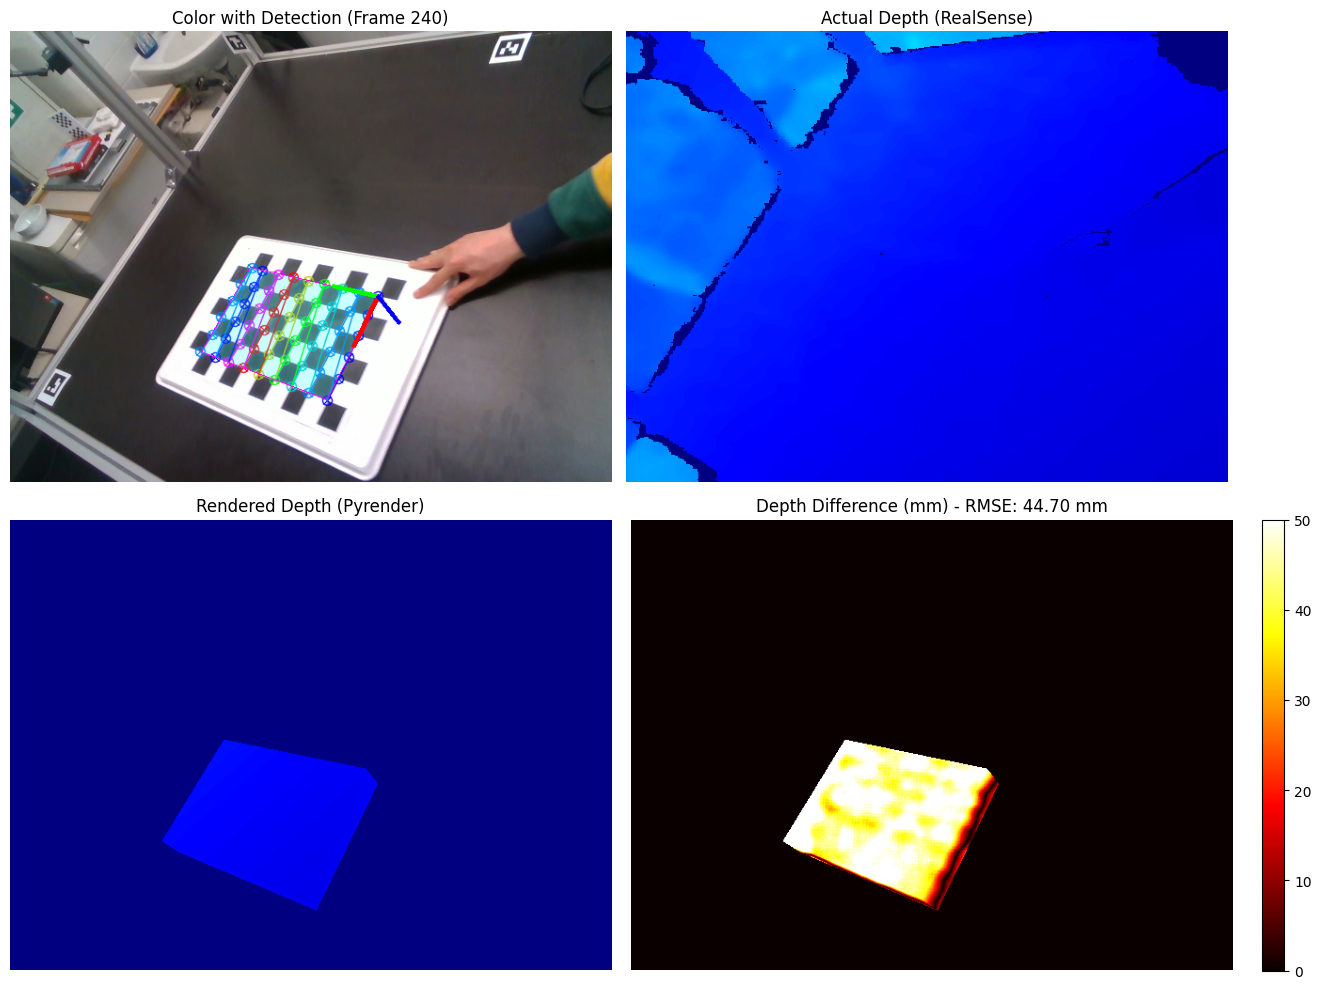


Processed 250 frames
RMSE Statistics (across 173 frames with detections):
  Mean RMSE: 47.70 mm
  Std RMSE:  2.76 mm
  Min RMSE:  42.30 mm
  Max RMSE:  53.80 mm
Done!


In [57]:

# Start pipeline
profile = pipeline.start(config)
# Create offscreen renderer
renderer = pyrender.OffscreenRenderer(img_width, img_height)

# Create figure for displaying images (now with 4 subplots)
fig = plt.figure(figsize=(14, 10))

try:
    frame_count = 0
    max_frames = 250
    rmse_values = []

    while frame_count < max_frames:
        # Wait for frames
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)

        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()

        if not color_frame or not depth_frame:
            print("End of bag file or no frames available")
            break

        # Convert images to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())
        
        # Convert depth to meters
        depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
        actual_depth_meters = depth_image.astype(np.float32) * depth_scale

        # Process checkerboard
        image_with_corners, found, corners2 = process_checkerboard(color_image, checkerboard_size, criteria)

        rendered_depth = None
        rmse = np.nan
        
        # If checkerboard is found, estimate pose and render
        if found and corners2 is not None:
            # Solve PnP
            success, rvec, tvec = cv2.solvePnP(objp, corners2, camera_matrix, dist_coeffs)
            
            if success:
                # Draw 3D axis and mask
                image_with_corners = draw_board_mask(image_with_corners, rvec, tvec, camera_matrix, dist_coeffs, checkerboard_size, square_size)
                image_with_corners = draw_3d_axis(image_with_corners, rvec, tvec, camera_matrix, dist_coeffs, axis_length=0.1)
                
                # Convert OpenCV pose to pyrender pose
                board_pose = opencv_to_pyrender_pose(rvec, tvec)
                
                # Update mesh pose in the scene
                scene.set_pose(mesh_node, pose=board_pose)
                
                # Render the depth
                rendered_depth = render_depth(scene, renderer, img_width, img_height)
                
                # Create mask for the board region
                mask = create_board_mask(rvec, tvec, camera_matrix, dist_coeffs, checkerboard_size, square_size, color_image.shape)
                
                # Compute RMSE
                rmse = compute_rmse(rendered_depth, actual_depth_meters, mask)
                rmse_values.append(rmse)

        # Visualization (every 10th frame)
        if frame_count % 10 == 0:
            clear_output(wait=True)
            
            # Clear figure and recreate subplots
            fig.clear()
            axes = fig.subplots(2, 2)
            ax_color, ax_depth, ax_rendered, ax_comparison = axes.flatten()
            
            # Color image with detections
            ax_color.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_RGB2RGBA))
            ax_color.set_title(f'Color with Detection (Frame {frame_count})')
            ax_color.axis('off')
            
            # Actual depth (colormap)
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            ax_depth.imshow(cv2.cvtColor(depth_colormap, cv2.COLOR_BGR2RGB))
            ax_depth.set_title('Actual Depth (RealSense)')
            ax_depth.axis('off')
            
            # Rendered depth
            if rendered_depth is not None:
                # Convert rendered depth to uint16 for visualization
                rendered_depth_vis = (rendered_depth * 1000).astype(np.uint16)  # Convert to mm
                rendered_colormap = cv2.applyColorMap(cv2.convertScaleAbs(rendered_depth_vis, alpha=0.03), cv2.COLORMAP_JET)
                ax_rendered.imshow(cv2.cvtColor(rendered_colormap, cv2.COLOR_BGR2RGB))
                ax_rendered.set_title('Rendered Depth (Pyrender)')
            else:
                ax_rendered.text(0.5, 0.5, 'No Detection', ha='center', va='center', transform=ax_rendered.transAxes)
                ax_rendered.set_title('Rendered Depth (Pyrender)')
            ax_rendered.axis('off')
            
            # Comparison (difference map)
            if rendered_depth is not None:
                # Compute absolute difference in mm
                diff = np.abs(actual_depth_meters - rendered_depth) * 1000  # Convert to mm
                diff[actual_depth_meters == 0] = 0  # Mask out invalid depth
                diff[rendered_depth == 0] = 0
                
                # Visualize difference (clip to reasonable range for visualization)
                diff_vis = np.clip(diff, 0, 50)  # Clip to 50mm for better visualization
                im = ax_comparison.imshow(diff_vis, cmap='hot', vmin=0, vmax=50)
                ax_comparison.set_title(f'Depth Difference (mm) - RMSE: {rmse*1000:.2f} mm' if not np.isnan(rmse) else 'Depth Difference (mm)')
                fig.colorbar(im, ax=ax_comparison, fraction=0.046, pad=0.04)
            else:
                ax_comparison.text(0.5, 0.5, 'No Detection', ha='center', va='center', transform=ax_comparison.transAxes)
                ax_comparison.set_title('Depth Difference')
            ax_comparison.axis('off')
            
            plt.tight_layout()
            display(fig)

        frame_count += 1

    print(f"\n{'='*60}")
    print(f"Processed {frame_count} frames")
    
    # Compute statistics on RMSE values
    valid_rmse = [r for r in rmse_values if not np.isnan(r)]
    if valid_rmse:
        print(f"RMSE Statistics (across {len(valid_rmse)} frames with detections):")
        print(f"  Mean RMSE: {np.mean(valid_rmse)*1000:.2f} mm")
        print(f"  Std RMSE:  {np.std(valid_rmse)*1000:.2f} mm")
        print(f"  Min RMSE:  {np.min(valid_rmse)*1000:.2f} mm")
        print(f"  Max RMSE:  {np.max(valid_rmse)*1000:.2f} mm")
    else:
        print("No valid RMSE values computed (no checkerboard detections)")
    print(f"{'='*60}")

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
finally:
    pipeline.stop()
    renderer.delete()
    plt.close()
    print("Done!")


### Summary of Implementation

The complete implementation includes:

1. **Checkerboard Mesh Creation**: 
   - Created a box mesh with dimensions matching the 6x9 checkerboard (each square is 4cm)
   - Properly scaled and translated to match OpenCV's coordinate system
   - The box has a thickness of 5mm to represent the physical board

2. **Coordinate System Conversion**:
   - Converted from OpenCV coordinate system (X right, Y down, Z forward) to pyrender (X right, Y up, Z backward)
   - Applied a 180-degree rotation around X-axis using a flip matrix

3. **Rendering and Comparison**:
   - Used pyrender's offscreen renderer to generate depth maps
   - Created masks to isolate the checkerboard region
   - Computed RMSE between rendered and actual depth values

4. **Visualization**:
   - Shows 4 views: Color with detection, Actual depth, Rendered depth, and Difference map
   - Displays RMSE statistics for all frames with successful detections

The rendered depth should closely match the actual depth from RealSense when the checkerboard is properly detected and tracked.
